<a href="https://colab.research.google.com/github/ZoubirCHATTI/09_Image_segmentation/blob/main/Brain%20Mask%20Segmentation%20with%20Deep%20Learning%20(U-Net)/Brainmask_seg_with_Unet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Brain Mask Segmentation with Deep Learning**







The goal of this workshop is to test a "basic" U-Net network for the segmentation of a brain MRI.

Main Python packages used:
Tensorflow and Keras for deep learning
nibabel for handling 3D volumes in nifti format
numpy and matplotlib

Training will be performed with a dataset of T1-weighted (T1w) images from a single 3D volume (split into 146 2D slices) and their associated masks (binary mask: 1 = brain, 0 = other).

Testing will be performed on two different datasets, namely the same training dataset and another dataset consisting of a single 3D volume (one subject) composed of 69 T1w slices and associated masks.

The first exercise will be to train the U-Net network from a single image and evaluate the performance.
The second exercise will highlight the contribution of Data Augmentation (DA) to improve the network's performance and robustness.

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import nibabel as nib
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, BatchNormalization, concatenate, ReLU, LeakyReLU, Add, Activation, Input, MaxPool2D, MaxPooling2D, GlobalAveragePooling2D, AveragePooling2D, UpSampling2D, Dropout, Lambda
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras import backend as K
from tensorflow.keras import layers
from skimage.transform import resize
from scipy.spatial.distance import directed_hausdorff
# Note: The original notebook imported from both keras and tensorflow.keras.
# We standardize to tensorflow.keras where possible for modern TF versions.
# Keras backend is kept as K for the dice function definition.

Install the gdown package (via pip) to download archives from Google Drive:

https://clay-atlas.com/us/blog/2021/07/01/python-en-gdown-package-download-file-google-drive/

In [2]:
!pip install gdown

In [3]:
!gdown https://drive.google.com/uc?id=17gb7VFUgoHzUWc3eH_gxdmNekLLZQEIO

Downloading...
From: https://drive.google.com/uc?id=17gb7VFUgoHzUWc3eH_gxdmNekLLZQEIO
To: /content/training.zip
100% 3.00M/3.00M [00:00<00:00, 95.1MB/s]


In [4]:
!gdown https://drive.google.com/uc?id=16-bZCe4whMnMfBjXBZwhPS16Uxet_x07

Downloading...
From: https://drive.google.com/uc?id=16-bZCe4whMnMfBjXBZwhPS16Uxet_x07
To: /content/testing.zip
100% 2.40M/2.40M [00:00<00:00, 249MB/s]


In [5]:
!unzip training

Archive:  training.zip
replace training/T1_0089.nii.gz? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: training/T1_0089.nii.gz  
  inflating: training/mask_0088.nii.gz  
  inflating: training/T1_0097.nii.gz  
  inflating: training/mask_0096.nii.gz  
  inflating: training/mask_0084.nii.gz  
  inflating: training/T1_0085.nii.gz  
  inflating: training/mask_0053.nii.gz  
  inflating: training/T1_0052.nii.gz  
  inflating: training/mask_0030.nii.gz  
  inflating: training/T1_0131.nii.gz  
  inflating: training/mask_0130.nii.gz  
  inflating: training/T1_0031.nii.gz  
  inflating: training/T1_0040.nii.gz  
  inflating: training/mask_0141.nii.gz  
  inflating: training/T1_0140.nii.gz  
  inflating: training/mask_0041.nii.gz  
  inflating: training/T1_0023.nii.gz  
  inflating: training/mask_0122.nii.gz  
  inflating: training/T1_0123.nii.gz  
  inflating: training/mask_0022.nii.gz  
  inflating: training/T1_0076.nii.gz  
  inflating: training/mask_0077.nii.gz  
  inflating: training/ma

In [6]:
!unzip testing

Archive:  testing.zip
replace testing/mask_0053.nii.gz? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: testing/mask_0053.nii.gz  
  inflating: testing/T1_0052.nii.gz  
  inflating: testing/mask_0030.nii.gz  
  inflating: testing/T1_0031.nii.gz  
  inflating: testing/T1_0040.nii.gz  
  inflating: testing/mask_0041.nii.gz  
  inflating: testing/T1_0023.nii.gz  
  inflating: testing/mask_0022.nii.gz  
  inflating: testing/T1_0015.nii.gz  
  inflating: testing/mask_0014.nii.gz  
  inflating: testing/T1_0068.nii.gz  
  inflating: testing/mask_0018.nii.gz  
  inflating: testing/T1_0019.nii.gz  
  inflating: testing/mask_0065.nii.gz  
  inflating: testing/T1_0064.nii.gz  
  inflating: testing/mask_0006.nii.gz  
  inflating: testing/T1_0007.nii.gz  
  inflating: testing/T1_0021.nii.gz  
  inflating: testing/mask_0020.nii.gz  
  inflating: testing/T1_0042.nii.gz  
  inflating: testing/mask_0043.nii.gz  
  inflating: testing/mask_0032.nii.gz  
  inflating: testing/T1_0033.nii.gz  
  inflat

Q1: Write a function that reads a pair of images (T1, mask) in "nii.gz" format from a dataset (training or testing),

inputs: path, index

Use nib.load

variables t1, mask for loading

and get_fdata() to retrieve the image matrix

Use the zfill function to handle the index:

txt = "50"

x = txt.zfill(10)

print(x)

In [7]:
def read_image_nii(folder_path, index):
    # List all files in the folder
    files = sorted(os.listdir(folder_path))

    # Separate T1 and MASK files (case-insensitive check for "t1_" and "mask_")
    t1_files = sorted([f for f in files if f.lower().startswith("t1_")])
    mask_files = sorted([f for f in files if f.lower().startswith("mask_")])

    # Load the T1 and mask file at the given index
    t1_img = nib.load(os.path.join(folder_path, t1_files[index]))
    mask_img = nib.load(os.path.join(folder_path, mask_files[index]))

    # Get the image data as a numpy array
    t1_data = t1_img.get_fdata()
    mask_data = mask_img.get_fdata()

    return (t1_data, mask_data)


In [8]:
mon_index=5
t1_data,mask_data=read_image_nii("/content/training/", mon_index)
print("2D image size: ", t1_data.shape)

2D image size:  (128, 128)


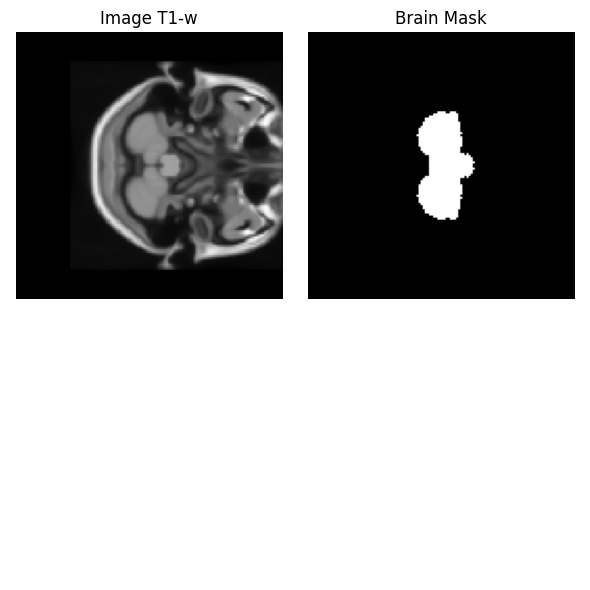

Total number of slices in the training set: 146
Total number of slices in the testing set: 69


In [9]:
plt.figure(figsize=(6,6))
plt.axis('Off')
plt.subplot(2,2,1)
plt.imshow(t1_data, cmap="gray")
plt.title('Image T1-w')
plt.axis('off')
plt.subplot(2,2,2)
plt.title("Brain Mask")
plt.imshow(mask_data, cmap="gray")
plt.axis('Off')
plt.tight_layout()
plt.show()
# Get the number of images in the training dataset
# Use os.listdir and filter for T1 files to get the count
files = os.listdir("/content/training")
t1_files = [f for f in files if f.lower().startswith("t1_")]
nb_images = len(t1_files)
test_files = os.listdir("/content/testing")
test1_files = [f for f in test_files if f.lower().startswith("t1_")]
nb_images_testing = len(test1_files)


print(f"Total number of slices in the training set: {nb_images}")
print(f"Total number of slices in the testing set: {nb_images_testing}")

Q2: Create two numpy arrays X_train, Y_train of size (my_index, 128, 128, 1) that respectively store the T1w images and binary masks.

Create two numpy arrays X_test, Y_test of size (number_of_images - 1, 128, 128, 1) that respectively store the T1w images and binary masks.

Note:

could not broadcast input array from shape (128,128) into shape (128,128,1)

-> use image_data = np.expand_dims(image_data, axis=-1)

In [12]:
train_counter=0
test_counter=0
X_train=np.zeros((nb_images, 128, 128, 1))
Y_train=np.zeros((nb_images, 128, 128, 1))
X_test=np.zeros((nb_images_testing, 128, 128, 1))
Y_test=np.zeros((nb_images_testing, 128, 128, 1))
for slice_index in range(0 ,nb_images):
    t1_data, mask_data = read_image_nii("/content/training/", slice_index)
    mask_data = np.expand_dims(mask_data, axis=-1)
    t1_data = np.expand_dims(t1_data, axis=-1)
    X_train[train_counter]=t1_data
    Y_train[train_counter]=mask_data
    train_counter+=1

for slice_index in range(nb_images_testing):
  te1_data, mask_te_data=read_image_nii("/content/testing/", slice_index)
  mask_te_data = np.expand_dims(mask_te_data, -1)
  te1_data = np.expand_dims(te1_data, -1)
  X_test[test_counter]=te1_data
  Y_test[test_counter]=mask_te_data
  test_counter+=1

In [13]:
# --- U-Net Model Definition ---
def unet_model(input_size=(128, 128, 1), dropout_rate=0.0):
    inputs = Input(input_size)

    # Normalization (0-255 to 0-1)
    s = Lambda(lambda x: x / 255)(inputs)
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
    c1 = Dropout(dropout_rate)(c1)
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)

    # Block 2 (64x64)
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
    c2 = Dropout(dropout_rate)(c2)
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)

    # Block 3 (32x32)
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
    c3 = Dropout(dropout_rate)(c3)
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)

    # Block 4 (16x16)
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
    c4 = Dropout(dropout_rate)(c4)
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
    p4 = MaxPooling2D(pool_size=(2, 2))(c4)
    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
    c5 = Dropout(dropout_rate)(c5)
    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)
    u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = concatenate([u6, c4]) # Skip connection
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
    c6 = Dropout(dropout_rate)(c6)
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)

    # Block 7 (32x32)
    u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = concatenate([u7, c3]) # Skip connection
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
    c7 = Dropout(dropout_rate)(c7)
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)

    # Block 8 (64x64)
    u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = concatenate([u8, c2]) # Skip connection
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
    c8 = Dropout(dropout_rate)(c8)
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)

    # Block 9 (128x128)
    u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = concatenate([u9, c1], axis=3) # Skip connection
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
    c9 = Dropout(dropout_rate)(c9)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)

    # Output layer (1x1 convolution to get 1 channel, sigmoid for binary segmentation)
    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c9)

    return Model(inputs=[inputs], outputs=[outputs])

In [14]:
model = unet_model()

In [15]:
# --- Model Compilation ---
# The original notebook suggests testing other loss functions (like dice_coef_loss)
# but uses binary_crossentropy for the initial run.

model.compile(optimizer='adam', loss="binary_crossentropy", metrics=['accuracy'])
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda (Lambda)     │ (None, 128, 128,  │          0 │ input_layer[0][0] │
│                     │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 128, 128,  │        160 │ lambda[0][0]      │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 128, 128,  │          0 │ conv2d[0][0]      │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 128, 128,  │      2,320 │ dropout[0][0]     │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 64, 64,    │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 64, 64,    │      4,640 │ max_pooling2d[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 64, 64,    │          0 │ conv2d_2[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 64, 64,    │      9,248 │ dropout_1[0][0]   │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 32, 32,    │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 32, 32,    │     18,496 │ max_pooling2d_1[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 32, 32,    │          0 │ conv2d_4[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 32, 32,    │     36,928 │ dropout_2[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 16, 16,    │          0 │ conv2d_5[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 16, 16,    │     73,856 │ max_pooling2d_2[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 16, 16,    │          0 │ conv2d_6[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 16, 16,    │    147,584 │ dropout_3[0][0] 

 Total params: 1,940,817 (7.40 MB)

 Trainable params: 1,940,817 (7.40 MB)

 Non-trainable params: 0 (0.00 B)

In [16]:
# --- U-Net Training (Exercise 1: Single Slice) ---
# Training with only one slice (X_train, Y_train) and no validation split (valid=0.0)
# This is the first exercise to demonstrate the concept.

batch_size = 1
epochs = 100

checkpointer = ModelCheckpoint(".keras", verbose=1, save_best_only=True, mode='min')
earlystopper = EarlyStopping(monitor='val_loss', patience=10, verbose=1)


print(f"Starting training with {epochs} epochs on a single slice...")
results = model.fit(X_train, Y_train, validation_split=0.1, batch_size=batch_size, epochs=epochs, callbacks=[earlystopper, checkpointer])

Starting training with 100 epochs on a single slice...
Epoch 1/100
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8902 - loss: 0.3175
Epoch 1: val_loss improved from inf to 0.03449, saving model to .keras
131/131 ━━━━━━━━━━━━━━━━━━━━ 19s 22ms/step - accuracy: 0.8905 - loss: 0.3164 - val_accuracy: 0.9911 - val_loss: 0.0345
Epoch 2/100
126/131 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9759 - loss: 0.0583
Epoch 2: val_loss improved from 0.03449 to 0.02786, saving model to .keras
131/131 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9761 - loss: 0.0579 - val_accuracy: 0.9875 - val_loss: 0.0279
Epoch 3/100
130/131 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9884 - loss: 0.0303
Epoch 3: val_loss improved from 0.02786 to 0.01747, saving model to .keras
131/131 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9884 - loss: 0.0303 - val_accuracy: 0.9924 - val_loss: 0.0175
Epoch 4/100
129/131 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9890 - loss: 0.0293
Epoch 4: val_loss impro

In [17]:
# --- Save Model ---
model.save('my_first_model.h5')
print("Model saved as 'my_first_model.h5'")

Model saved as 'my_first_model.h5'


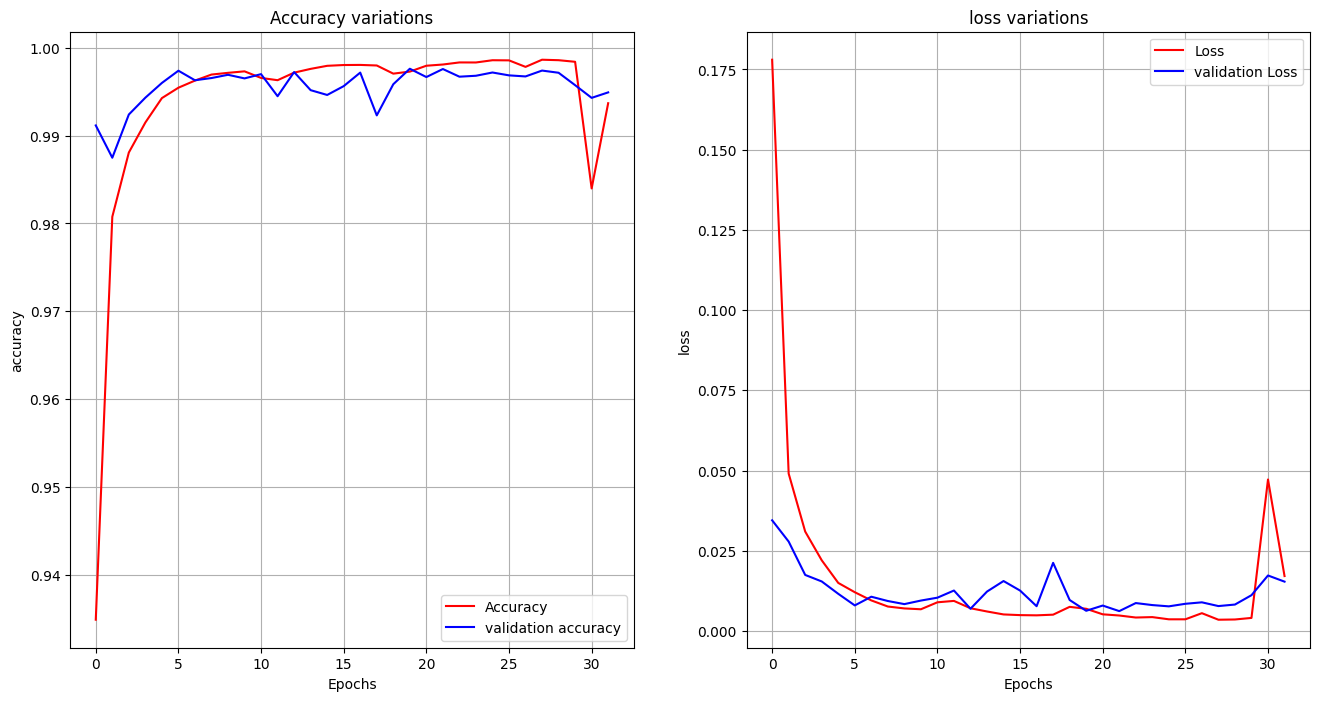

In [18]:
# --- Learning Curve (Accuracy and Loss on Training Dataset) ---
plt.figure(figsize=(16,8))
plt.subplot(1, 2 , 1)
plt.title("Accuracy variations")
plt.plot(results.history["accuracy"], label="Accuracy", color='r')
plt.plot(results.history["val_accuracy"], label="validation accuracy", color='b')
plt.xlabel("Epochs")
plt.ylabel("accuracy")
plt.legend()
plt.grid(True)
plt.subplot(1 , 2 , 2)
plt.title("loss variations")
plt.plot(results.history["loss"], label="Loss", color='r')
plt.plot(results.history["val_loss"], label="validation Loss", color='b')

plt.xlabel("Epochs")
plt.ylabel("loss")
plt.legend()
plt.grid(True)
plt.show()



In [19]:
def dice_coef(y_true, y_pred, smooth=1):

    intersection = K.sum(K.abs(y_true * y_pred), axis=-1)
    return (2. * intersection + smooth) / (K.sum(K.square(y_true),-1) + K.sum(K.square(y_pred),-1) + smooth)

def dice_coef_loss(y_true, y_pred):
    return 1-dice_coef(y_true, y_pred)

# Implementarion DICE SCORE COEFFICIENT for testing of images
def dice(pred, true, k = 1):
    intersection = np.sum(pred[true==k]) * 2.0

    dice = intersection / (np.sum(pred) + np.sum(true) + 1e-8)
    return dice

# Implementation HAUSDORFF DISTANCE for testing of images
def hausdorff_distance (pred, true):
  haus = max(directed_hausdorff(pred, true)[0], directed_hausdorff(true, pred)[0])
  return haus

In [20]:
test_preds = model.predict(X_test)
# Threshold the predictions to get a binary mask (0 or 1)
preds_test_thresh = (test_preds >= 0.5).astype(np.uint8)

all_dice_testing = []
all_hausdorff_testing = []

# Loop through all test slices
for slice_index in range(len(X_test)):
    # Extract the true mask and the predicted mask
    img_true = Y_test[slice_index, :, :, 0]
    img_pred_th = preds_test_thresh[slice_index, :, :, 0]

    # Calculate Dice Score
    dice_score = dice(img_pred_th, img_true)
    all_dice_testing.append(dice_score)

    # Calculate Hausdorff Distance
    hd_score = hausdorff_distance(img_pred_th, img_true)
    all_hausdorff_testing.append(hd_score)

print(f"Mean Dice Score on Test Set: {np.mean(all_dice_testing):.4f}")
print(f"Mean Hausdorff Distance on Test Set: {np.mean(all_hausdorff_testing):.4f}")

3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 807ms/step
Mean Dice Score on Test Set: 0.8365
Mean Hausdorff Distance on Test Set: 3.7743


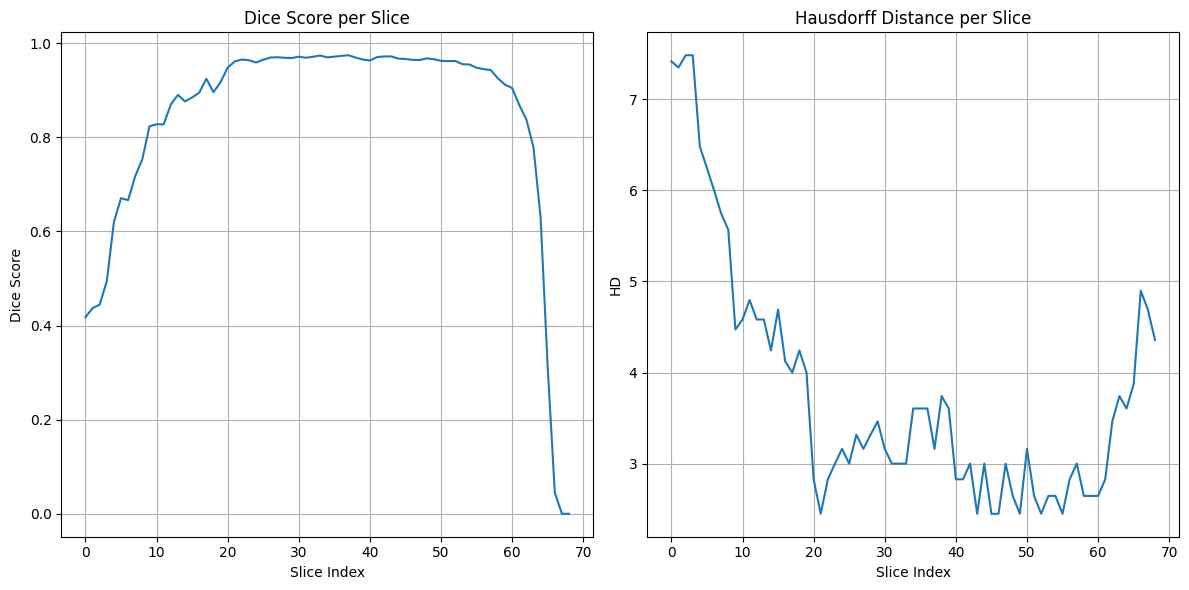

In [21]:
# --- Plotting Metrics per Slice ---
plt.figure(figsize=(12,6))

# Plot Dice Score
plt.subplot(1,2,1)
plt.plot(all_dice_testing)
plt.grid(True)
plt.title("Dice Score per Slice")
plt.xlabel("Slice Index")
plt.ylabel("Dice Score")

# Plot Hausdorff Distance
plt.subplot(1,2,2)
plt.plot(all_hausdorff_testing)
plt.grid(True)
plt.title("Hausdorff Distance per Slice")
plt.xlabel("Slice Index")
plt.ylabel("HD")

plt.tight_layout()
plt.show()


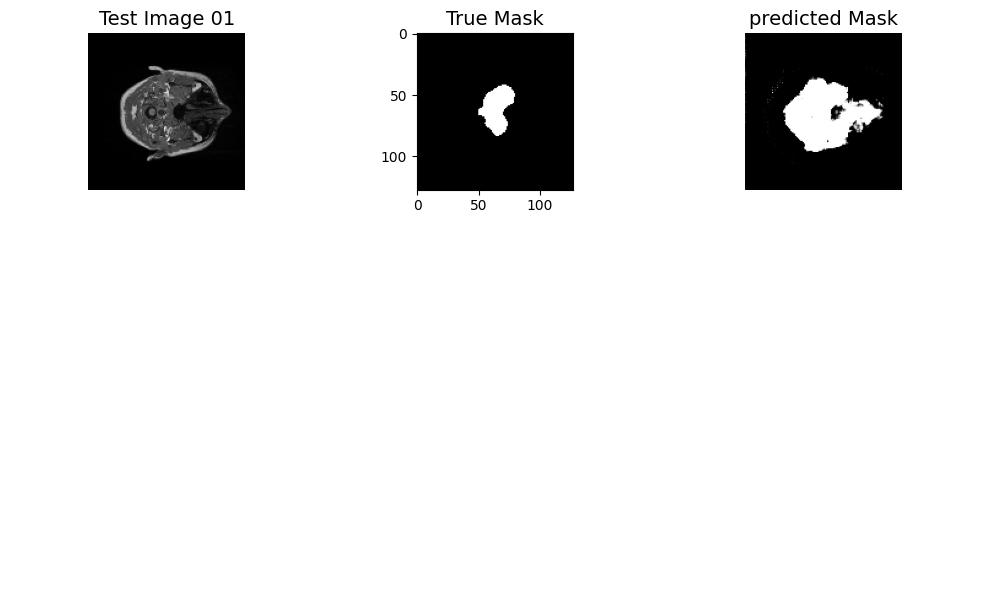

In [31]:
plt.figure(figsize=(10,6))
plt.axis('Off')

Slide_row_1=0

# == row 1 ==
plt.subplot(3,3,1)
test_image = X_test[Slide_row_1, :, :, 0]
plt.imshow(test_image, cmap='gray')
plt.title('Test Image 01', fontsize=14)
plt.axis('off')

# true mask
plt.subplot(3,3,2)
true_mask=Y_test[Slide_row_1, :, :, 0]
plt.imshow(true_mask, cmap='gray')
plt.title('True Mask', fontsize=14)

plt.subplot(3,3,3)
inf_mask=test_preds[Slide_row_1, :, :, 0]
plt.imshow(inf_mask, cmap='gray')
plt.title('predicted Mask', fontsize=14)

plt.axis('off')

plt.tight_layout()
plt.show()

In [26]:
!pip install Keras-Preprocessing

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 3.9 MB/s eta 0:00:00


In [32]:
# Data Augmentation

from tensorflow.keras import layers

data_augmentation = tf.keras.Sequential([
                        layers.RandomFlip(mode="horizontal_and_vertical", seed=1),
                        layers.RandomRotation(factor=0.20, fill_mode="constant", fill_value=0, seed=1),
                        layers.RandomZoom(height_factor=(0.3,-0.3), fill_mode='constant', fill_value=0, seed=1)])

X_train_augmented = X_train
Y_train_augmented = Y_train

for x in range(5):
  ds_concatenate = np.concatenate((X_train_augmented,Y_train_augmented), axis=3)
  ds_concatenate_augmented=data_augmentation(ds_concatenate)

  X_train_augmented=ds_concatenate_augmented[:,:,:,0:1]
  X_train_augmented=np.concatenate((X_train,X_train_augmented), axis=0)

  Y_train_augmented=ds_concatenate_augmented[:,:,:,1:2]
  Y_train_augmented=np.concatenate((Y_train,Y_train_augmented), axis=0)



In [33]:
layers.RandomContrast

keras.src.layers.preprocessing.image_preprocessing.random_contrast.RandomContrast

146


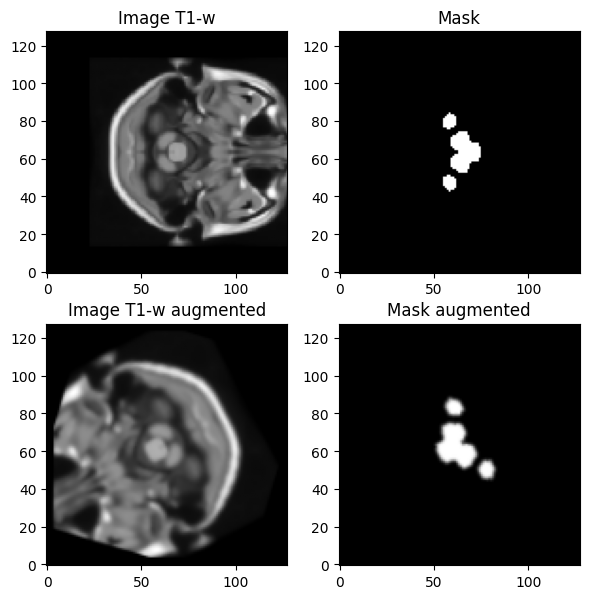

Total images for training without data augmentation =  146
Total images for training with data augmentation =  876


In [34]:
Y_train_augmented.shape
print (len(X_train))

plt.figure(figsize=(6,6))
plt.axis('Off')
Slide_show=1
plt.subplot(2,2,1)
plt.imshow(X_train_augmented[Slide_show,:,:,0],cmap="gray", origin="lower")
plt.title('Image T1-w')
plt.subplot(2,2,2)
plt.title("Mask")
plt.imshow(Y_train_augmented[Slide_show,:,:,0],cmap="gray", origin="lower")
plt.tight_layout()
plt.subplot(2,2,3)
plt.imshow(X_train_augmented[Slide_show + 3*len(X_train),:,:,0],cmap="gray", origin="lower")
plt.title('Image T1-w augmented')
plt.subplot(2,2,4)
plt.title("Mask augmented")
plt.imshow(Y_train_augmented[Slide_show + 3*len(X_train) ,:,:,0],cmap="gray", origin="lower")
plt.tight_layout()
plt.show()

print("Total images for training without data augmentation = ",(X_train.shape)[0])
print("Total images for training with data augmentation = ", (X_train_augmented.shape)[0])

In [35]:
# Unet training
earlystopper = EarlyStopping(monitor='val_loss', patience=10, verbose=1)
CKPT_path = "my_model.weights.h5"
checkpointer = ModelCheckpoint(".keras", verbose=1, save_best_only=True, mode='min')
results_augmented = model.fit(X_train_augmented, Y_train_augmented, validation_split=0.1, batch_size=15, epochs=150, callbacks=[earlystopper, checkpointer])

Epoch 1/150
52/53 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.8995 - loss: 0.0375
Epoch 1: val_loss improved from inf to 0.04190, saving model to .keras
53/53 ━━━━━━━━━━━━━━━━━━━━ 3s 55ms/step - accuracy: 0.8995 - loss: 0.0374 - val_accuracy: 0.8132 - val_loss: 0.0419
Epoch 2/150
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.8990 - loss: 0.0351
Epoch 2: val_loss did not improve from 0.04190
53/53 ━━━━━━━━━━━━━━━━━━━━ 4s 36ms/step - accuracy: 0.8990 - loss: 0.0351 - val_accuracy: 0.8132 - val_loss: 0.0420
Epoch 3/150
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.8964 - loss: 0.0356
Epoch 3: val_loss did not improve from 0.04190
53/53 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - accuracy: 0.8964 - loss: 0.0356 - val_accuracy: 0.8131 - val_loss: 0.0421
Epoch 4/150
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.9013 - loss: 0.0324
Epoch 4: val_loss improved from 0.04190 to 0.04137, saving model to .keras
53/53 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - accuracy: 0.9013 - loss: 0

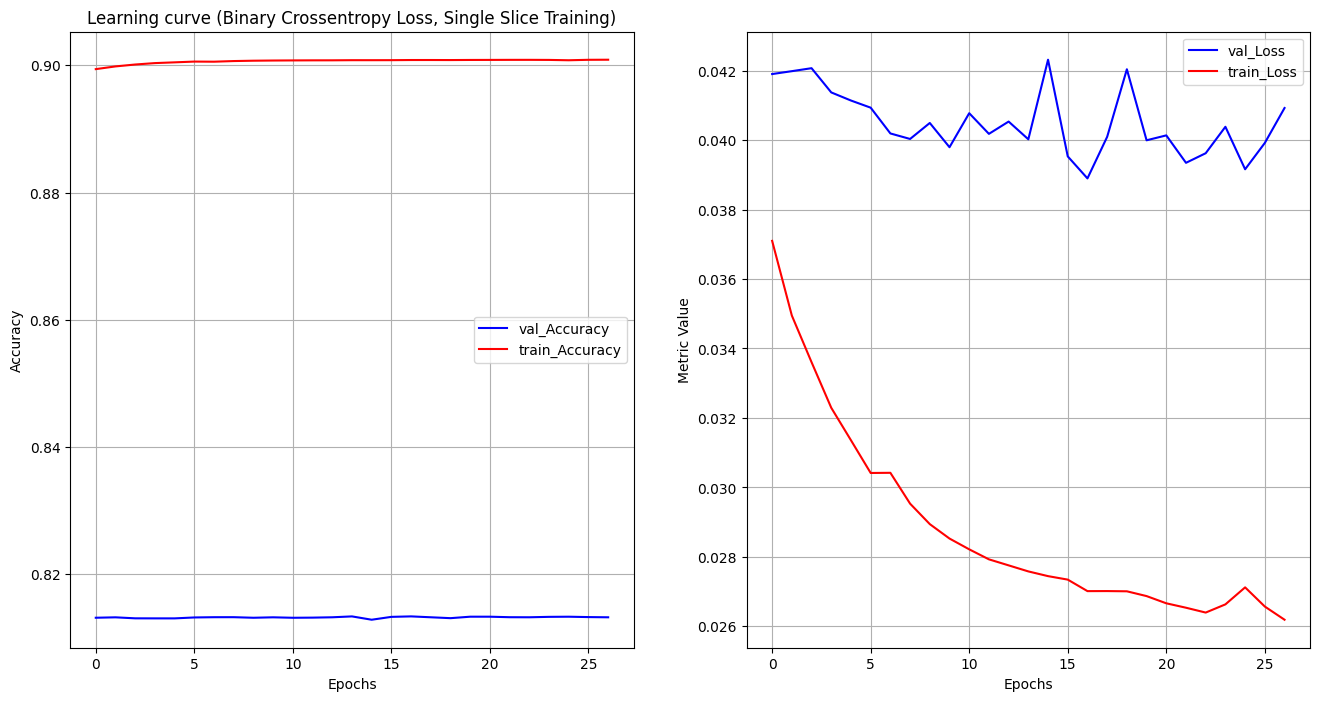

In [36]:
# --- Learning Curve (Accuracy and Loss on Training Dataset) ---
plt.figure(figsize=(16,8))
plt.subplot(1, 2 ,1)
plt.title("Learning curve (Binary Crossentropy Loss, Single Slice Training)")
plt.plot(results_augmented.history["val_accuracy"], label="val_Accuracy", color='b')
plt.plot(results_augmented.history["accuracy"], label="train_Accuracy", color='r')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.subplot(1 , 2 , 2)
plt.plot(results_augmented.history["val_loss"], label="val_Loss", color='b')
plt.plot(results_augmented.history["loss"], label="train_Loss", color='r')
plt.xlabel("Epochs")
plt.ylabel("Metric Value")
plt.grid(True)
plt.legend()
plt.show()


In [37]:
# --- Prediction and Metric Calculation on Test Set (from Training Data) ---
test_preds_augmented = model.predict(X_test)
# Threshold the predictions to get a binary mask (0 or 1)
preds_test_thresh_augmented = (test_preds_augmented >= 0.5).astype(np.uint8)

all_dice_testing_augmented = []
all_hausdorff_testing_augmented = []

# Loop through all test slices
for slice_index in range(len(X_test)):
    # Extract the true mask and the predicted mask
    img_true = Y_test[slice_index, :, :, 0]
    img_pred_th = preds_test_thresh_augmented[slice_index, :, :, 0]

    # Calculate Dice Score
    dice_score = dice(img_pred_th, img_true)
    all_dice_testing_augmented.append(dice_score)

    # Calculate Hausdorff Distance
    hd_score = hausdorff_distance(img_pred_th, img_true)
    all_hausdorff_testing_augmented.append(hd_score)

print(f"Mean Dice Score on Test Set: {np.mean(all_dice_testing_augmented):.4f}")
print(f"Mean Hausdorff Distance on Test Set: {np.mean(all_hausdorff_testing_augmented):.4f}")

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Mean Dice Score on Test Set: 0.8720
Mean Hausdorff Distance on Test Set: 3.2225


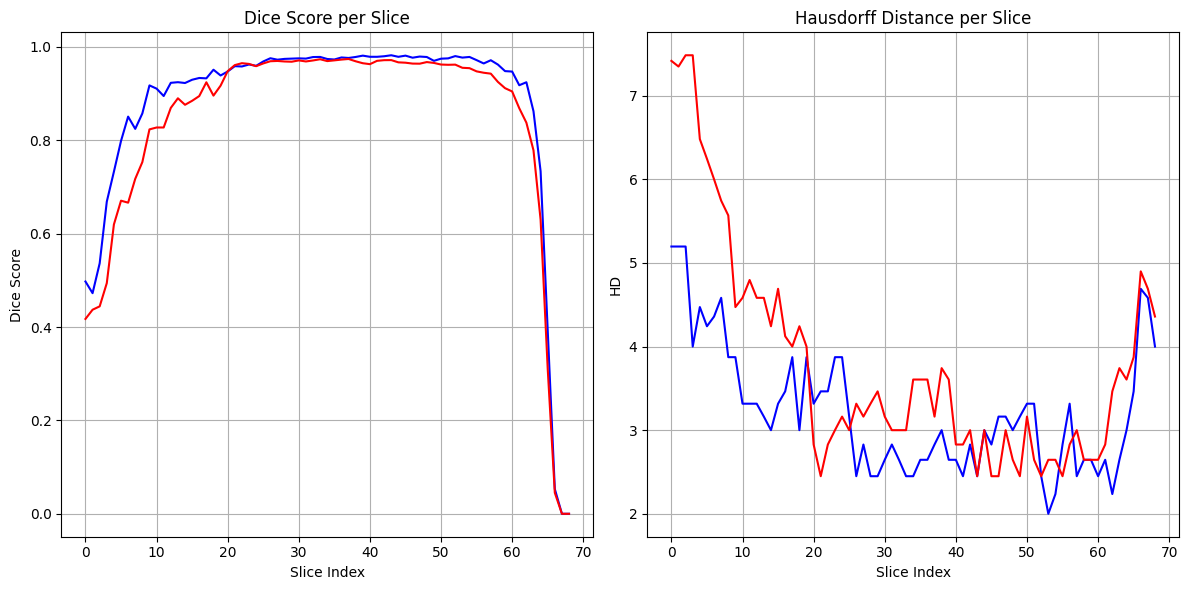

In [38]:
# --- Plotting Metrics per Slice ---
plt.figure(figsize=(12,6))

# Plot Dice Score
plt.subplot(1,2,1)
plt.plot(all_dice_testing_augmented, color='b')
plt.plot(all_dice_testing, color='r')
plt.grid(True)
plt.title("Dice Score per Slice")
plt.xlabel("Slice Index")
plt.ylabel("Dice Score")

# Plot Hausdorff Distance
plt.subplot(1,2,2)
plt.plot(all_hausdorff_testing_augmented, color='b')
plt.plot(all_hausdorff_testing, color='r')
plt.title("Hausdorff Distance per Slice")
plt.xlabel("Slice Index")
plt.ylabel("HD")
plt.grid(True)
plt.tight_layout()
plt.show()